# Setup 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, Input, Dropout, GlobalAveragePooling2D,concatenate
from PIL import Image
import numpy as np
import PIL.ImageOps 
import csv
import zipfile
import os
import cv2
from natsort import natsorted
from keras.applications.vgg16 import VGG16 #, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd



In [ ]:
!pip install split-folders --quiet

Mount to Google Drive folder. Make sure the folder `malaria_project` is inside `MyDrive`. If it is in `shared with me` right click and make a shortcut to `MyDrive`. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#*Variables*

In [ ]:
BATCH_SIZE=16
EPOCHS = 5

### Setting up the satellite data
First we split the satellite images into `test`,`train`, and `validation` folders

# TODO: Change it such that the entire satellite folder is within malaria_project

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/x_data/x2", output="output",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) # (train:validation:test)


Copying files: 5133 files [01:02, 82.00 files/s]


As we are going to use `DataFrames` to our `ImageDataGenerators` we need to create them such that the entire filename is the `x_col` entry, and we can access the label. It is required that the name of the entry in `x_col` has the exact same name as the satellite image in order to match them.

In [ ]:
'''
This function is responsible for creating the dataframe containing the labels and image data
'''
def createDataFrame(label_dir, data_dir, ending=True):
  #Retrieve the filenames and ids.
  filenames = []
  ids = []
  for file in os.listdir(data_dir):
    if file == ".DS_Store":
      continue
    filenames.append(file)
    if ending:
      ids.append(file.split("_")[0])
    else:
      ids.append(file.split(".")[0])
  #Create empty DataFrame
  df = pd.DataFrame()
  #Append the data
  df['filename'] = filenames
  df['id'] = ids

  #Append the labels
  start_list = []
  with open(label_dir) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for i,line in enumerate(csv_reader):
      #print(line[0])
      id = line[0]
      pr = line[4]
      for img in filenames:
        if ending:
          img_id = img.split('_')[0]
        else:
          img_id = img.split(".")[0]
          
        if img_id == id:
          index = np.where(df["filename"] == img)
          start_list.append(float(pr))
    df['label'] = start_list
  return df.sort_values(by='id')

Creating the `DataFrames`

In [ ]:
train_data_dir = 'output/train/satellite_data_v2'
test_data_dir = 'output/test/satellite_data_v2'
val_data_dir = 'output/val/satellite_data_v2'
label_dir = '/content/drive/MyDrive/malaria_project/long_lat_year_with_confidential_from2010to18_size10orGreater.csv'
train_df = createDataFrame(label_dir=label_dir, data_dir=train_data_dir)
test_df = createDataFrame(label_dir=label_dir, data_dir=test_data_dir)
val_df = createDataFrame(label_dir=label_dir, data_dir=val_data_dir)

### Setting up the landcover data

In [ ]:
'''Finding the names of the files that needs to be copied'''
x_names = []
for file_name in os.listdir("/content/drive/MyDrive/x_data/x2/satellite_data_v2"):
  x_names.append(file_name.split("_")[0])

In [ ]:
'''Loops through the images and copies the corresponding land cover'''
import os
import shutil

source_folder = r"/content/drive/MyDrive/malaria_project/landcover_cropped_with_confi_2010_2018_size10andGreater"
if not os.path.exists('landcover_full'):
   os.makedirs('landcover_full')
destination_folder = r"landcover_full"

for file_name in os.listdir(source_folder):
  for x_name in x_names:
    if file_name.split(".")[0] == x_name:
      source = source_folder + "/"+ file_name
      destination = destination_folder + "/" + file_name
      shutil.copy(source, destination)

In [ ]:
# #crop the landcovers
# for i,image in enumerate(os.listdir("landcover_full")):
#     if image == ".DS_Store" or image ==".ipynb_checkpoints":
#         continue
#     img = Image.open("landcover_full/"+image)
#     if img.size != (8, 8):
#       img = img.resize((8,8))
#       img.save('landcover_full/'+image, 'TIFF')


As we have the images locally we can split it into folders. First we create all the directories and then we copy the images into the correct ones, according to the satellite data. 

In [ ]:
#create the directories
if not os.path.exists('output_landcover'):
   os.makedirs('output_landcover')
#testing
if not os.path.exists('output_landcover/test'):
   os.makedirs('output_landcover/test')
if not os.path.exists('output_landcover/test/landcover'):
   os.makedirs('output_landcover/test/landcover')
#training
if not os.path.exists('output_landcover/train'):
   os.makedirs('output_landcover/train')
if not os.path.exists('output_landcover/train/landcover'):
   os.makedirs('output_landcover/train/landcover')
#validation
if not os.path.exists('output_landcover/val'):
   os.makedirs('output_landcover/val')
if not os.path.exists('output_landcover/val/landcover'):
   os.makedirs('output_landcover/val/landcover')

In [ ]:
'''Copies the files from the landcover directory to the correct splitted folders'''
def copyfiles(dir, src_dir, dest_dir):
  for file_name in os.listdir(dir):
    file_name_no_coords = file_name.split("_")[0]
    source = src_dir + file_name_no_coords + ".tiff"
    destination = dest_dir + file_name_no_coords + ".tiff"
    shutil.copy(source, destination)
  
copyfiles(dir="output/test/satellite_data_v2", src_dir="landcover_full/", dest_dir="output_landcover/test/landcover/")
copyfiles(dir="output/train/satellite_data_v2", src_dir="landcover_full/", dest_dir="output_landcover/train/landcover/")
copyfiles(dir="output/val/satellite_data_v2", src_dir="landcover_full/", dest_dir="output_landcover/val/landcover/")

Lastly we can create the `DataFrames`

In [ ]:
train_data_dir_landcover = 'output_landcover/train/landcover'
test_data_dir_landcover = 'output_landcover/test/landcover'
val_data_dir_landcover = 'output_landcover/val/landcover'
label_dir_landcover = '/content/drive/MyDrive/malaria_project/long_lat_year_with_confidential_from2010to18_size10orGreater.csv'
train_landcover_df = createDataFrame(label_dir=label_dir_landcover, data_dir=train_data_dir_landcover, ending=False)
test_landcover_df = createDataFrame(label_dir=label_dir_landcover, data_dir=test_data_dir_landcover, ending=False)
val_landcover_df = createDataFrame(label_dir=label_dir_landcover, data_dir=val_data_dir_landcover, ending=False)

## Constructing the `ImageDataGenerators`

In [ ]:
#Satellite
imgen_sat = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_sat = imgen_sat.flow_from_dataframe(dataframe=train_df, 
                                            directory=train_data_dir, 
                                            x_col="filename", 
                                            y_col="label", 
                                            has_ext=True,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE, 
                                            class_mode="other", 
                                            target_size=(1024,1024))

val_generator_sat = imgen_sat.flow_from_dataframe(dataframe=val_df, 
                                            directory=val_data_dir, 
                                            x_col="filename", 
                                            y_col="label", 
                                            has_ext=True,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE, 
                                            class_mode="other", 
                                            target_size=(1024,1024))

test_generator_sat = imgen_sat.flow_from_dataframe(dataframe=test_df, 
                                            directory=test_data_dir, 
                                            x_col="filename", 
                                            y_col="label", 
                                            has_ext=True,
                                            shuffle=True,
                                            batch_size=1, 
                                            class_mode="other", 
                                            target_size=(1024,1024))

#Landcover
imgen_lc = ImageDataGenerator()
train_generator_lc = imgen_lc.flow_from_dataframe(dataframe=train_landcover_df, 
                                            directory=train_data_dir_landcover, 
                                            x_col="filename", 
                                            y_col="label", 
                                            has_ext=True,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE, 
                                            class_mode="other", 
                                            target_size=(8,8))

val_generator_lc = imgen_lc.flow_from_dataframe(dataframe=val_landcover_df, 
                                            directory=val_data_dir_landcover, 
                                            x_col="filename", 
                                            y_col="label", 
                                            has_ext=True,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE, 
                                            class_mode="other", 
                                            target_size=(8,8))

test_generator_lc = imgen_lc.flow_from_dataframe(dataframe=test_landcover_df, 
                                            directory=test_data_dir_landcover, 
                                            x_col="filename", 
                                            y_col="label", 
                                            has_ext=True,
                                            shuffle=True,
                                            batch_size=1, 
                                            class_mode="other", 
                                            target_size=(8,8))



Found 3593 validated image filenames.
Found 1026 validated image filenames.
Found 514 validated image filenames.
Found 3593 validated image filenames.
Found 1026 validated image filenames.
Found 514 validated image filenames.


In [ ]:
class JoinedGen(tf.keras.utils.Sequence):
    '''
    This clas is reponsible for manipulating the outputs of the generators 
    to have the correct form which our model can take as input. It takes two 
    ImageDataGenerator instances as input.

    Args: 
        input_gen1: An ImageDataGenerator instance.
        input_gen2: An ImageDataGenerator instance
    '''
    def __init__(self, input_gen1, input_gen2):
        self.gen1 = input_gen1
        self.gen2 = input_gen2

        assert len(input_gen1) == len(input_gen2)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1,y1 = self.gen1[i]
        x2,y2 = self.gen2[i]

        return [x1,x2],y1 #as the labels are always the same, we can simply output the first.

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen2.index_array = self.gen1.index_array #responsible for shuffling


## Constructing the model

###Toy model

In [ ]:
'''Toy model'''
sat_input = keras.Input(shape=(1024,1024,3))
lc_input = keras.Input(shape=(8,8,3))

x = MaxPooling2D((128,128))(sat_input)
x = concatenate([x,lc_input])
x = Flatten()(x)
x = Dense(1, activation="linear")(x)
new_simple_model = Model(inputs=[sat_input, lc_input], outputs=x) 
new_simple_model.compile(optimizer='adam', loss='mse')
summary = new_simple_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 3)     0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 8, 8, 3)]    0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8, 8, 6)      0           ['max_pooling2d_1[0][0]',  

In [ ]:
my_gen = JoinedGen(train_generator_sat, train_generator_lc)
vgg_history = new_simple_model.fit(my_gen,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            steps_per_epoch=train_generator_sat.samples//BATCH_SIZE,
                            #validation_data=val_generator,
                            #,
                            #validation_steps=n_val_steps,
                            #callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

### Advanced model VGG

In [ ]:
sat_input = keras.Input(shape=(1024,1024,3))
# sat_input = sat_input[0,:,:,:]
# print(sat_input.shape)
lc_input = keras.Input(shape=(8,8,3))


base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(1024, 1024,3))

# baseModel = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet',input_tensor=image_input)

#freeze layers
for layer in base_model1.layers:
    layer.trainable = False

x = base_model1.output #mobilenet_v2 output shape (32, 5, 5, 1280) #vgg 7 7 52
x = MaxPooling2D((4,4))(x)
# x_lc = MaxPooling2D((2,2))(lc_input)
x = concatenate([x,lc_input])
x = Flatten()(x)
x = Dense(1, activation="linear")(x)
# new_simple_model = Model(inputs=[sat_input, lc_input], outputs=x) 
new_simple_model = Model(inputs=[base_model1.input, lc_input], outputs=x) 

# new_simple_model = Model(inputs=base_model1.input, outputs=x) #maybe TODO change input to some sat

new_simple_model.compile(optimizer='adam', loss='mse')
summary = new_simple_model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(new_simple_model, show_shapes = True, show_layer_names=True)

In [ ]:
my_gen = JoinedGen(train_generator_sat, train_generator_lc)
vgg_history = new_simple_model.fit(my_gen,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            steps_per_epoch=train_generator_sat.samples//BATCH_SIZE,
                            #validation_data=val_generator,
                            #,
                            #validation_steps=n_val_steps,
                            #callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

Epoch 1/5
 879/3593 [======>.......................] - ETA: 5:06 - loss: 4669.6479

KeyboardInterrupt: ignored

### Advanced model mobilenetV2

In [ ]:
sat_input = keras.Input(shape=(1024,1024,3))
# sat_input = sat_input[0,:,:,:]
# print(sat_input.shape)
lc_input = keras.Input(shape=(8,8,3))


base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(1024, 1024,3))

# baseModel = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet',input_tensor=image_input)

#freeze layers
for layer in base_model1.layers:
    layer.trainable = False

x = base_model1.output #this has shape 32, 32, 1280 .  ??mobilenet_v2 output shape (32, 5, 5, 1280)?? #vgg 7 7 52
x = MaxPooling2D((4,4))(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(filters=16,kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=3)(x)
x = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization(axis=-1)(x)
x = GlobalAveragePooling2D()(x)


# Landcover model
x_lc = MaxPooling2D((2,2))(lc_input)
x_lc = Conv2D(filters=16,kernel_size=3, padding="same", activation="relu")(x_lc)
x_lc = BatchNormalization(axis=-1)(x_lc)
x_lc = MaxPooling2D(pool_size=3)(x_lc)
x_lc = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x_lc)
x_lc = BatchNormalization(axis=-1)(x_lc)
# x_lc = MaxPooling2D(pool_size=3)(x_lc)
x_lc = Flatten()(x_lc)

# Combine
x = concatenate([x,x_lc])
x = Flatten()(x)
x = Dense(1, activation="linear")(x)
# with_mobilenet_model = Model(inputs=[sat_input, lc_input], outputs=x) 
with_mobilenet_model = Model(inputs=[base_model1.input, lc_input], outputs=x) 

# with_mobilenet_model = Model(inputs=base_model1.input, outputs=x) #maybe TODO change input to some sat

with_mobilenet_model.compile(optimizer='adam', loss='mse')
summary = with_mobilenet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 512, 32  864         ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 512, 512, 32  128         ['Conv1[0][0]']                  
                                )                                                           

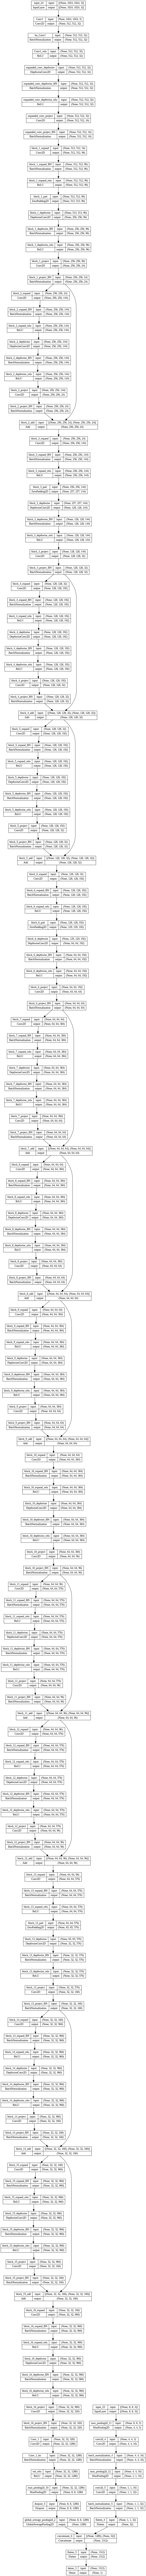

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(with_mobilenet_model, show_shapes = True, show_layer_names=True)

In [ ]:
!pip install livelossplot --quiet


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping


my_gen = JoinedGen(train_generator_sat, train_generator_lc)
my_gen_val = JoinedGen(val_generator_sat, val_generator_lc)

# n_steps = my_gen.samples // BATCH_SIZE
# n_val_steps = my_gen_val.samples // BATCH_SIZE

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True,
                           mode='min')

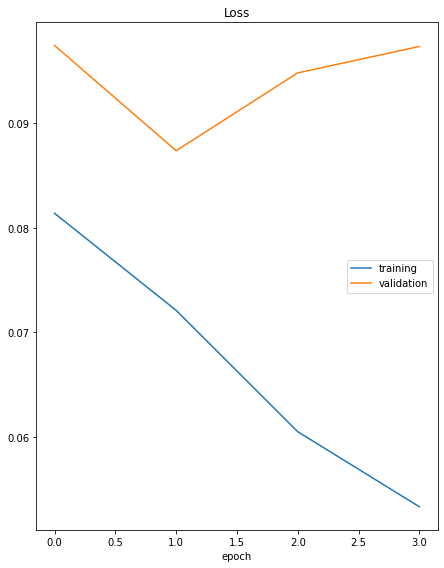

Loss
	training         	 (min:    0.053, max:    0.081, cur:    0.053)
	validation       	 (min:    0.087, max:    0.097, cur:    0.097)
224/224 [==============================] - 298s 1s/step - loss: 0.0533 - val_loss: 0.0974


In [ ]:


# my_gen_validation = JoinedGen()
vgg_history = with_mobilenet_model.fit(my_gen,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            steps_per_epoch=train_generator_sat.samples//BATCH_SIZE,
                            validation_data=my_gen_val,
                            # validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

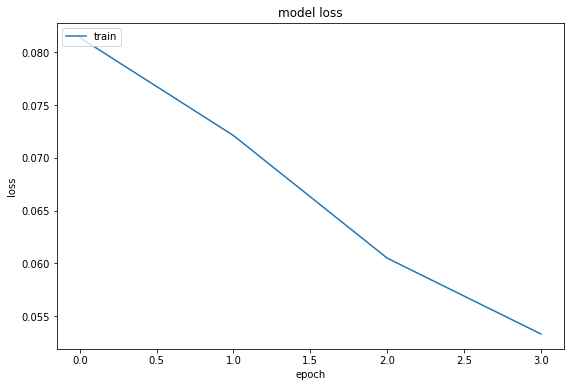

<ipython-input-74-c8591640cbc7>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results = with_mobilenet_model.evaluate_generator(generator= my_gen_test,


0.09086672216653824


In [ ]:
show_history(vgg_history)

my_gen_test = JoinedGen(test_generator_sat, test_generator_lc)

results = with_mobilenet_model.evaluate_generator(generator= my_gen_test, 
                                                  steps=len(my_gen_test))
# print("Test loss: " + str(results[0]))
print(results)

# score = with_mobilenet_model.evaluate(x=[x_test,x_test_land_cover], y=y_test, verbose=0)
# print('Test loss:', score)
# test_predictions = with_mobilenet_model.predict(x=[x_test,x_test_land_cover]).flatten()

# a = plt.axes(aspect='equal')
# plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values ')
# plt.ylabel('Predictions')
# lims = [0, 1]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [ ]:
predictions = with_mobilenet_model.predict_generator(generator= my_gen_test, 
                                                  steps=len(my_gen_test))

<ipython-input-75-59d8684549e6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = with_mobilenet_model.predict_generator(generator= my_gen_test,


In [ ]:
print(len(predictions))

514


208    0.476190
113    0.052632
159    0.300000
244    0.000000
465    0.000000
         ...   
468    0.125000
233    0.500000
306    0.600000
43     0.048780
452    0.727273
Name: label, Length: 514, dtype: float64


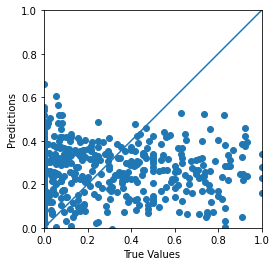

In [ ]:
y_test = test_df['label']
print(y_test)
a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)